# Modeling Reversal Task

### RW model of the reversal task in the aging experiment

The aim of this notbook is to see if age affects appetative reversal learning.

participants have 70 trials 40% reinforced.

reversal of stimuli occurs after 35 trials.

This notbook is based on Or's simulation of SCR.

## load libraries

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import pingouin as pg
import os

import pymc3 as pm
import arviz as az
import statsmodels.api as sm
import statsmodels.formula.api as smf

from glob import glob

## Get data

make sure only participant with complete data set are loaded

In [29]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'

db = pd.DataFrame()

for sub in glob(glober):
    
    try:
        df = pd.read_csv(sub)
        df['sub'] = sub.split('_')[2]
        if df.shape[0] == 70:
            db = pd.concat([db, df], axis = 0)
            #db = db.append(df)#[df.trialNum<36])
    except:
        print(sub)
        print('error')

#db['rating'] = db['rating'].replace(0, np.nan)
db = db.sort_values(by=['sub','trialNum'])
print('number of subject: ', len(db['sub'].unique()))

number of subject:  72


In [30]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

age.columns.values[0] = "sub"
moca.columns.values[0] = "sub"
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
print("number of participants with age and moca scores: ",age.shape[0])

number of participants with age and moca scores:  63


In [31]:
db['sub'] = db['sub'].astype('int')
db = db.merge(age, left_on='sub', right_on='sub')
db = db[db.moca_score >25]
print('Valid subjects: ', len(np.unique(db['sub'])))

Valid subjects:  47


## get descriptive data

In [32]:
n_subj   = len(db['sub'].unique())
n_trials = max(db.trialNum)

trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj   = tt.as_tensor_variable(subj.T)

In [33]:
stim   = np.reshape([db['rectOri']],   (n_subj, n_trials)).T
reward = np.reshape([db['rectValue']], (n_subj, n_trials)).T
rating = np.reshape([db['rating']],    (n_subj, n_trials)).T

stim   = np.array(stim/45,  dtype='int')
reward = np.array(reward/6*9, dtype='int')

In [34]:
stim = tt.as_tensor_variable(stim)
reward = tt.as_tensor_variable(reward)

# create a pymc3 model

In [35]:
 
# generate functions to run
def update_Q(stim, reward,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
     
    PE = reward - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

In [9]:
# try alpha as beta distribution
with pm.Model() as mB:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1035 seconds.


In [10]:
az.summary(trB, var_names='alpha')[:20]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.024,0.018,0.000,0.056,0.0,0.0,3895.0,2138.0,1.0
alpha[1],0.024,0.010,0.006,0.044,0.0,0.0,5571.0,2510.0,1.0
alpha[2],0.006,0.005,0.000,0.015,0.0,0.0,3218.0,2208.0,1.0
alpha[3],0.029,0.020,0.000,0.065,0.0,0.0,4256.0,2461.0,1.0
alpha[4],0.022,0.010,0.003,0.039,0.0,0.0,3458.0,1771.0,1.0
alpha[5],0.013,0.011,0.000,0.033,0.0,0.0,4916.0,3031.0,1.0
alpha[6],0.006,0.005,0.000,0.016,0.0,0.0,3582.0,2455.0,1.0
alpha[7],0.004,0.004,0.000,0.011,0.0,0.0,3402.0,2155.0,1.0
alpha[8],0.011,0.009,0.000,0.027,0.0,0.0,3481.0,2064.0,1.0
alpha[9],0.016,0.012,0.000,0.037,0.0,0.0,4300.0,2239.0,1.0


In [11]:
# try with intercept
with pm.Model() as mB_I:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_I = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 829 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
az.summary(trB_I, var_names='alpha')[:20]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.469,0.272,0.000,0.875,0.010,0.007,883.0,1514.0,1.01
alpha[1],0.115,0.116,0.001,0.275,0.004,0.003,1563.0,856.0,1.00
alpha[2],0.085,0.079,0.000,0.226,0.002,0.002,1226.0,1879.0,1.00
alpha[3],0.296,0.099,0.121,0.479,0.002,0.001,2950.0,2508.0,1.00
alpha[4],0.094,0.091,0.001,0.201,0.003,0.002,1714.0,1349.0,1.00
alpha[5],0.453,0.268,0.000,0.916,0.005,0.004,2801.0,2208.0,1.00
alpha[6],0.390,0.240,0.003,0.827,0.006,0.004,1981.0,1615.0,1.00
alpha[7],0.421,0.107,0.228,0.628,0.003,0.002,1647.0,2021.0,1.00
alpha[8],0.345,0.255,0.000,0.819,0.006,0.005,1697.0,2283.0,1.01
alpha[9],0.562,0.246,0.126,0.996,0.004,0.003,3125.0,2059.0,1.00


In [13]:
az.compare({'model1': trB, 'model2':trB_I})

/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnin

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model1,0,-11977.564927,113.574510,0.000000,0.757643,41.082523,0.000000,False,log
model2,1,-12061.238900,119.857351,83.673974,0.242357,38.566724,18.721937,True,log


In [36]:
# try with random intercept
with pm.Model() as mB_Is:
    
   # betaHyper= pm.Normal('betaH', 0, 1)
    intercept = pm.Normal('intercept', 0, 5, shape=n_subj)
    
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 5, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    rates = pm.Normal('rates', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trB_Is = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3704 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
az.summary(trB_Is, var_names='alpha')[:20]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.339,0.238,0.000,0.782,0.005,0.004,1390.0,674.0,1.0
alpha[1],0.531,0.139,0.288,0.808,0.002,0.002,4137.0,2028.0,1.0
alpha[2],0.100,0.184,0.000,0.517,0.005,0.004,2017.0,1910.0,1.0
alpha[3],0.457,0.318,0.000,0.923,0.010,0.007,951.0,903.0,1.0
alpha[4],0.259,0.094,0.093,0.427,0.001,0.001,5122.0,2607.0,1.0
alpha[5],0.356,0.280,0.000,0.859,0.006,0.004,1920.0,1490.0,1.0
alpha[6],0.155,0.163,0.000,0.454,0.004,0.003,1961.0,1433.0,1.0
alpha[7],0.135,0.227,0.000,0.714,0.004,0.003,2967.0,2129.0,1.0
alpha[8],0.355,0.293,0.000,0.886,0.006,0.004,1595.0,1102.0,1.0
alpha[9],0.264,0.307,0.000,0.887,0.006,0.004,1734.0,1941.0,1.0


In [16]:
az.compare({'model1': trB, 'model2':trB_I, 'model3':trB_Is})

/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnin

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-11927.134520,172.814712,0.000000,0.770465,42.253480,0.000000,False,log
model1,1,-11977.564927,113.574510,50.430407,0.210247,41.082523,13.799741,False,log
model2,2,-12061.238900,119.857351,134.104381,0.019288,38.566724,17.207161,True,log


## hierarchal model

In [17]:
# try alpha as beta distribution
with pm.Model() as m_H:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 4.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 4.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, reward],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj] + intercept[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr_hB = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi, intercept_matt, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6671 seconds.
There were 188 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
az.summary(tr_hB, var_names='alpha')[:10]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.015,0.022,0.0,0.060,0.001,0.001,287.0,331.0,1.01
alpha[1],0.017,0.018,0.0,0.049,0.001,0.001,191.0,180.0,1.02
alpha[2],0.002,0.005,0.0,0.009,0.000,0.000,450.0,614.0,1.00
alpha[3],0.100,0.094,0.0,0.258,0.012,0.009,71.0,162.0,1.05
alpha[4],0.017,0.017,0.0,0.048,0.001,0.001,252.0,283.0,1.01
alpha[5],0.009,0.024,0.0,0.038,0.001,0.001,254.0,570.0,1.02
alpha[6],0.002,0.006,0.0,0.008,0.000,0.000,257.0,362.0,1.01
alpha[7],0.006,0.041,0.0,0.006,0.003,0.002,274.0,437.0,1.01
alpha[8],0.005,0.010,0.0,0.019,0.000,0.000,396.0,646.0,1.01
alpha[9],0.009,0.015,0.0,0.034,0.001,0.000,250.0,384.0,1.02


## model comparison

In [19]:
comp = az.compare({'model1': trB, 'model2':trB_I, 'model3':trB_Is, 'model4': tr_hB}, ic='loo')
comp

/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
/home/nachshon/anaconda3/envs/reversal/lib/python3.10/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnin

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model3,0,-11927.134520,172.814712,0.000000,6.499761e-01,42.253480,0.000000,False,log
model4,1,-11945.350051,106.596280,18.215531,3.500239e-01,39.506002,12.240918,True,log
model1,2,-11977.564927,113.574510,50.430407,1.193885e-12,41.082523,13.799741,False,log
model2,3,-12061.238900,119.857351,134.104381,0.000000e+00,38.566724,17.207161,True,log


<AxesSubplot:xlabel='Log'>

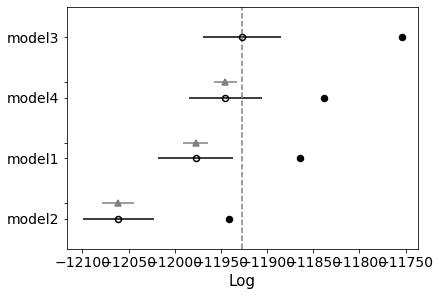

In [20]:
az.plot_compare(comp)

In [11]:
db.head()

,trialNum,rectOri,rectValue,rating,RT,sub,gender,age,moca_score
0,1,45,0,3,1.450375,14,F,26,30
1,2,0,0,7,1.366599,14,F,26,30
2,3,45,6,3,1.233494,14,F,26,30
3,4,45,0,7,0.850292,14,F,26,30
4,5,0,0,3,1.000125,14,F,26,30


In [41]:
alpha = az.summary(trB_Is, var_names=['alpha'])[['mean','sd']]
alpha['sub']=db['sub'].unique()
alpha = alpha.merge(age, left_on='sub', right_on='sub')
alpha['age'] = alpha['age'].astype('int')
alpha.head(10)

,mean,sd,sub,gender,age,moca_score
0,0.339,0.238,10,M,18,28
1,0.531,0.139,11,F,43,26
2,0.100,0.184,13,F,48,28
3,0.457,0.318,14,F,26,30
4,0.259,0.094,15,F,58,26
5,0.356,0.280,16,M,74,28
6,0.155,0.163,17,M,59,29
7,0.135,0.227,18,F,83,28
8,0.355,0.293,19,M,32,28
9,0.264,0.307,20,M,56,28


Text(0, 0.5, 'Alpha')

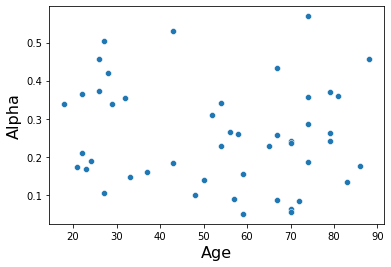

In [56]:

sns.scatterplot(x='age',y='mean', data=alpha)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Alpha', fontsize=16)

In [54]:
pg.corr(alpha['age'], alpha['mean'])

,n,r,CI95%,p-val,BF10,power
pearson,47,-0.098534,"[-0.38, 0.19]",0.50994,0.224,0.101125


In [55]:
alpha.to_csv('data/alpha.csv')